In [1]:
# %% init
import os
os.chdir("/home/tangir/crmbm/python/shrimp")

from IPython import get_ipython
get_ipython().magic("clear")
get_ipython().magic("matplotlib notebook")

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import mrs.reco as reco
import mrs.sim as sim
import mrs.db as db
import mrs.log as log
import numpy as np
import suspect
from datetime import datetime

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

# Select datasets
Maybe only sLASER R>10 and N=1 ?

In [3]:
rdb = db.data_db("/home/tangir/crmbm/acq_db/brain.pkl")
df = rdb.create_big_df()
df

(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/brain.pkl]...
(INFO)  data_db.create_big_df: extending dataframe by scraping data...
(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/brain.pkl]...


,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,reco_pipeline_analyze_job_list[3]_POI_shift_true_ppm,reco_pipeline_analyze_job_list[3]_display,reco_pipeline_analyze_job_list[3]_display_range_ppm[0],reco_pipeline_analyze_job_list[3]_display_range_ppm[1],reco_pipeline_analyze_enable,reco_pipeline_analyze_display,reco_pipeline__pipeline__isfrozen,fit_results,timestamp,reco_pipeline_settings_datasets_indexes
hash,,,,,,,,,,,,,,,,,,,,,
16d71eb60d555d564285780e3a956a3b,296,1,#0 brain - sLASER R:N=5:5,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(1072.6899923169685+51.74024474664252j), (992...",0.0001,297.206367,21.96,3000.0,...,4.7,True,1,6,True,True,True,None,2020-10-29 00:15:18.469092,None
b057a3e07319341e032e3c6c36ec4d83,296,1,#1 brain - sLASER R:N=25:1,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(689.0669802502591-136.65124370561344j), (671...",0.0001,297.206367,49.96,3500.0,...,4.7,True,1,6,True,True,True,None,2020-10-29 00:15:18.522405,None
c8c12d0843d056ad058d51fd96b360f5,308,1,#0 brain - sLASER 20:1 resp trig,/home/tangir/crmbm/acq_twix/308-rs-p1-moelle/m...,/home/tangir/crmbm/acq_twix/308-rs-p1-moelle/m...,"[(813.0401020344693-48.68837082080384j), (795....",0.0001,297.206456,49.96,3000.0,...,4.7,True,1,6,True,True,True,None,2020-10-29 00:16:47.856969,None
c7afef7aa25e055763846fa0ec43d26d,347,1,#0 sLASER 10:2 TE=30ms,/home/tangir/crmbm/acq_twix/347-re-p1-moelle/m...,/home/tangir/crmbm/acq_twix/347-re-p1-moelle/m...,"[(309.48049560871294+61.897647154302284j), (27...",0.0001,297.206385,30.28,3660.0,...,4.7,True,1,6,True,True,True,None,2020-10-29 00:17:08.403190,None


# Cohort & spectral quality

## Subject, height, weight, BMI
To check cohort characteristics

In [3]:
# calculate bmi
df["dataset_patient_bmi"] = df["dataset_raw_data__patient_weight"] / \
    df["dataset_raw_data__patient_height"]**2

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_raw_data__patient_weight"],
                df["dataset_raw_data__patient_height"],
                c=df["dataset_patient_bmi"],
                s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Patient weight (kg)", fontsize=11)
ax.set_ylabel("Patient height (m)", fontsize=11)
ax.set_title("Patient height vs. weight vs. BMI")
ax.grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

print("Mean weight = %.2fkgs +/-%.2f " % (df["dataset_raw_data__patient_weight"].mean(),
                                          df["dataset_raw_data__patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f " % (df["dataset_raw_data__patient_height"].mean(),
                                        df["dataset_raw_data__patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f " %
      (df["dataset_patient_bmi"].mean(), df["dataset_patient_bmi"].std()))

sex_counts = df["dataset_raw_data__patient_sex"].value_counts()
print("Sex = M(%d) F(%d)" % (sex_counts["M"], sex_counts["F"]))

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc461c310>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc461c310> on colorbar
(DEBUG) Setting pcolormesh


Mean weight = 62.50kgs +/-16.58 
Mean height = 1.73m +/-0.16 
Mean BMI = 20.38 +/-2.42 
Sex = M(1) F(3)


## Correlation $B_1$ power (reference voltage) vs. BMI?
Reference RF voltage increases with BMI

In [4]:
cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots(1, 2)
sc = ax[0].scatter(df["dataset_patient_bmi"],
                   df["dataset_raw_data__sequence_vref"], s=100, alpha=0.5)
ax[0].set_xlabel("Patient BMI", fontsize=11)
ax[0].set_ylabel("Reference voltage (V)", fontsize=11)
ax[0].set_title("Ref. voltage vs. BMI", fontsize=11)
ax[0].grid(True)

sc = ax[1].scatter(df["dataset_raw_data__patient_weight"], df["dataset_raw_data__patient_height"],
                   c=df["dataset_raw_data__sequence_vref"], s=100, alpha=0.5, cmap=cm)
ax[1].set_xlabel("Patient weight (kg)", fontsize=11)
ax[1].set_ylabel("Patient height (m)", fontsize=11)
ax[1].set_title("Patient height vs. height vs. Ref. voltage", fontsize=11)
ax[1].grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc510d050>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc510d050> on colorbar
(DEBUG) Setting pcolormesh


## Correlation voxel position vs. BMI?
Voxel position relative to magnet center increases with BMI

In [5]:
# add voxel position to df
df["dataset_raw_data_posX_mm"] = np.array(
    [o.position[0] for o in df["dataset_raw_data_obj"]])
df["dataset_raw_data_posY_mm"] = np.array(
    [o.position[1] for o in df["dataset_raw_data_obj"]])
df["dataset_raw_data_posZ_mm"] = np.array(
    [o.position[2] for o in df["dataset_raw_data_obj"]])

fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bmi"], -
                df["dataset_raw_data_posY_mm"], s=100, alpha=0.5)
ax.set_xlabel("Patient BMI", fontsize=11)
ax.set_ylabel("- Voxel Y position rel. to MRI center", fontsize=11)
ax.set_title("Patient BMI vs. voxel Y position", fontsize=11)
ax.grid(True)

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## Any correlation between SNR, LW, BMI?
SNR is normalized by:
* voxel size
* number of averages (post-data-rejection)
* voxel position in Y

Therefore
* SNR values are divided by voxel volume and multiplied by a mean volume to get usual SNR values
* SNR values are divided by $\sqrt(NA)$ kept after data rejection and multiplied by $\sqrt(128)$
* SNR values are multiplied by $(1+\frac{y^2}{R^2})^{\frac{2}{3}}$ and multiplied by $(1+\frac{y_{mean}^2}{R^2})^{\frac{2}{3}}$

According to the Biot–Savart law (Jackson, 1975), cited in https://doi.org/10.1201/9781315107325, the distance relative to the RF loop surface coil impacts SNR with a $(1+\frac{y^2}{R^2})^{\frac{2}{3}}$ term. $y$ is the absolute distance between the voxel and the RF coil, $R$ is the coil radius. $y_{mean}$ is the average $y$ position over the whole group.

The problem is to evaluate this absolute distance to coil when I only know the voxel position relative to the magnet center... Let's take the lowest voxel position in the study group, probably for the thinnest subject and consider that we were 4cm away from the coil.

Ok, another problem is that we were using a multi-channel Rx spinal cord coil. What do I put for the radius? Assuing a 14cm radius coil... Big approximation.

In [6]:
# for each SNR measurement, normalize by voxel size and number of averages
# dicom data will be rejected

# init SNR and LW with final estimations
df["dataset_snr_final"] = df["dataset_raw_analysis-results_cropping_snr"]
df["dataset_lw"] = df["dataset_raw_analysis-results_cropping_lw"]
df["dataset_snr_norm"] = df["dataset_raw_analysis-results_cropping_snr"]

# VOI normalization
# calculate voxel volume
df["dataset_voxel_vol_cm3"] = (np.array(list(df["dataset_raw_data_voxel_dimensions"])) / 10.0).prod()
mean_voxel_vol = df["dataset_voxel_vol_cm3"].mean()
df["dataset_snr_norm"] = df["dataset_snr_norm"] / df["dataset_voxel_vol_cm3"] * mean_voxel_vol

# NA normalization
na_norm = 128.0
df["dataset_snr_norm"] = df["dataset_snr_norm"] / np.sqrt(df["dataset_raw_data__data_rejection[0]_Post-rejection_na"]) * np.sqrt(na_norm)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm"], c=df["dataset_patient_bmi"], s=100, alpha=0.5, cmap=cm)
# ax.scatter(df["dataset_lw_final"], data_reco_brain["snr_norm"], s=100, alpha=0.5, c='green') for brain
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. LW vs. BMI (brain in green)")
ax.set_xlim([0, 60])
ax.grid(True)

plt.colorbar(sc)

# Y voxel position normalization
min_dist_voxel_coil_mm = 40.0  # mm
coil_radius_mm = 140.0 / 2  # mm 
# looking for minimum Y position
max_pos = np.max(df["dataset_raw_data_posY_mm"])
df["dataset_raw_data_posY_mm_abs"] = -(df["dataset_raw_data_posY_mm"] - max_pos) + min_dist_voxel_coil_mm
mean_abs_y_pos = df["dataset_raw_data_posY_mm_abs"].mean()
# normalization
df["dataset_snr_norm_voxpos"] = df["dataset_snr_norm"] * np.power(1 + np.power(df["dataset_raw_data_posY_mm_abs"], 2) / np.power(coil_radius_mm, 2), 3/2)
df["dataset_snr_norm_voxpos"] = df["dataset_snr_norm_voxpos"] / np.power(1 + np.power(mean_abs_y_pos, 2) / np.power(coil_radius_mm, 2), 3/2)

fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm_voxpos"], c=df["dataset_patient_bmi"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI+Ypos norm. SNR vs. LW vs. BMI (SC only)")
ax.set_xlim([0, 60])
ax.grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc517b510>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc517b510> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc47f1f90>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc47f1f90> on colorbar
(DEBUG) Setting pcolormesh


## Best, ok and worst spectra
According to SNR and LW and me

In [7]:
# finding best SNR spectrum in brain
best_snr_df = df.loc[df["dataset_snr_norm"] == df["dataset_snr_norm"].max()]
s = best_snr_df["dataset_raw_data_obj"][0]
s.display_spectrum_1d(100)
plt.title("Brain - Best SNR = %.2f (LW = %.2f)" % (best_snr_df["dataset_snr_norm"][0].max(), best_snr_df["dataset_lw"][0]))

# etc.


(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 brain - sLASER 20:1 resp trig [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Brain - Best SNR = 300.86 (LW = 17.90)')

# Does water LW from ref. data == WS data LW?

Interestingly, LW(NAA) and LW(water) are not necessary correlated on brain...


In [8]:
# extract lw from WS and noWS data
lw_list = df["dataset_raw_analysis-results_cropping_lw"]
lw_ref_list = df["dataset_raw_ref-data-analysis-results_lw"]

fig = plt.figure()
ax = fig.subplots()
ax.scatter(lw_list, lw_ref_list)

ax.grid('on')
ax.set_xlabel("LW (Hz)")
ax.set_ylabel("Ref. LW (Hz)")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Ref. LW (Hz)')

# Artefact around 5 ppm, why?
This artefact seems to increase when voxel size decreases in the $x$ dimension. The sLASER sequence is a *semi-*LASER sequence, meaning that not all spatial dimensions are selected using adiabatic RF pulses (like in LASER). The $x$ dimension is selected using a standard asymmetric RF sinc pulse while $y$ and $z$ are selected using HSn RF pulses.

I believe this artefact originates from badly localized signal in the $x$ dimension because of the poor efficiency of the half sinc selection pulse in inhomogenous $B_1$ situation (surface coil):
* This effect is increased when this bad pulse needs to select a small slice.
* Less clear but likely to happen, this effect is also increased when the VOI is far from the coil ($y$ position is high) and the $B_1$ inhomogeneity gets even more crazy.
* Could be gradient non-linearities too?

Need to try to correlate this, again, with shim voltages

In [9]:
# voxel dimensions in X, Y and Z:
df["dataset_voxel_size_X"] = np.array(list(df["dataset_raw_data_voxel_dimensions"]))[:, 0]
df["dataset_voxel_size_Y"] = np.array(list(df["dataset_raw_data_voxel_dimensions"]))[:, 1]
df["dataset_voxel_size_Z"] = np.array(list(df["dataset_raw_data_voxel_dimensions"]))[:, 2]

# estimate artefact intensity for each dataset
df["dataset_artefact_signal"] = np.array([o.analyze_snr_1d([4.8, 5.5], [-2, -1], True, True) for o in df["dataset_raw_data_obj"]])[:, 1]

# normalization of artefact SNR
df["dataset_artefact_signal_norm"] = df["dataset_artefact_signal"]
# VOI normalization
df["dataset_artefact_signal_norm"] = df["dataset_artefact_signal_norm"] / df["dataset_voxel_vol_cm3"] * mean_voxel_vol
# NA normalization
df["dataset_artefact_signal_norm"] = df["dataset_artefact_signal_norm"] / np.sqrt(df["dataset_raw_data__data_rejection[0]_Post-rejection_na"]) * np.sqrt(na_norm)

# find big artefact datasets
plt.figure(120)
artefact_df = df.loc[df["dataset_artefact_signal_norm"] > 200.0]
for s in artefact_df["dataset_raw_data_obj"]:
    s.display_spectrum_1d(120)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_voxel_size_X"], df["dataset_artefact_signal_norm"], c=df["dataset_patient_bmi"], s=10, alpha=0.5, cmap=cm)
ax.set_xlabel("X voxel size (mm)", fontsize=11)
ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
ax.set_yscale('log')
ax.set_title("Artefact level vs. X voxel size")
ax.grid(True)

plt.colorbar(sc0)

(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - sLASER R:N=5:5 [RAW]]...


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.80ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 brain - sLASER R:N=5:5 [RAW]] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 1.24E+04, N = 1.68E+02, SNR = 73.80!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 brain - sLASER R:N=25:1 [RAW]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.80ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 brain - sLASER R:N=25:1 [RAW]] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 8.72E+03, N = 1.21E+02, SNR = 72.18!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 brain - sLASER 20:1 resp trig [RAW]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.80ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  M

<IPython.core.display.Javascript object>

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 brain - sLASER R:N=5:5 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 brain - sLASER R:N=25:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 brain - sLASER 20:1 resp trig [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 10:2 TE=30ms [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc4fa6890>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc4fa6890> on colorbar
(DEBUG) Setting pcolormesh


# Does the moving average window size correlates with SNR?
Seems that some datasets with low SNR needed moving averaging for the frequency realignment and the data rejection to work. Could we maybe find a SNR threshold or a simple relation between SNR and moving average window size so that it is set automatically?

In [10]:
# extract SNR before realignment
snr_list = df["dataset_raw_analysis-results_zero-filling_snr"]
lw_list = df["dataset_raw_analysis-results_zero-filling_lw"]
na_realigning_list = df["reco_pipeline_job_realigning_moving_averages"]
na_datarej_list = df["reco_pipeline_job_realigning_moving_averages"]
            
fig = plt.figure()
ax = fig.subplots()
ax.scatter(snr_list, na_realigning_list)
ax.grid('on')
ax.set_xlabel("SNR")
ax.set_ylabel("Moving average window (realign)")

fig = plt.figure()
ax = fig.subplots()
ax.scatter(snr_list, na_datarej_list)
ax.grid('on')
ax.set_xlabel("SNR")
ax.set_ylabel("Moving average window (datarej)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Moving average window (datarej)')

# Shimming: what is the best? 1st vs. 2nd order?
- Did 2nd order shim help? Extracting data from notebooks.

In [11]:
# found this in my labbooks:
patient_list = [313,     319,     328, 329, 333, 336,  338,  300,    311,  336,  319,  313,  314,  349  ]
study_list = [    1,       1,       1,   1,   1,   1,    1,    2,      2,    1,    2,    2,    2,    2  ]
lw_linear = [    45,      25,      25,  30,  45,  30,   25,   35, np.nan,  np.nan,   39,   30,   20,   26  ]
lw_full = [      55,  np.nan,      40,  25,  50,  60,   35, 37.5,     25,   27,  np.nan,   50,   25,   30  ]

lw_linear = np.array(lw_linear)
lw_full = np.array(lw_full)
lw_diff = lw_full - lw_linear
lw_diff = lw_diff[~np.isnan(lw_diff)]
print("In average, there was a %.2fHz change for the water LW between 1st and 2nd order shimming!" % lw_diff.mean())


In average, there was a 9.65Hz change for the water LW between 1st and 2nd order shimming!


# Scan-time, number of averages and data rejection

## Theoretical, effective (gated) and post-cor. acquisition duration
Compare theory, effective acquisition durations and "useful" acquisition durations (post-correction)

<IPython.core.display.Javascript object>


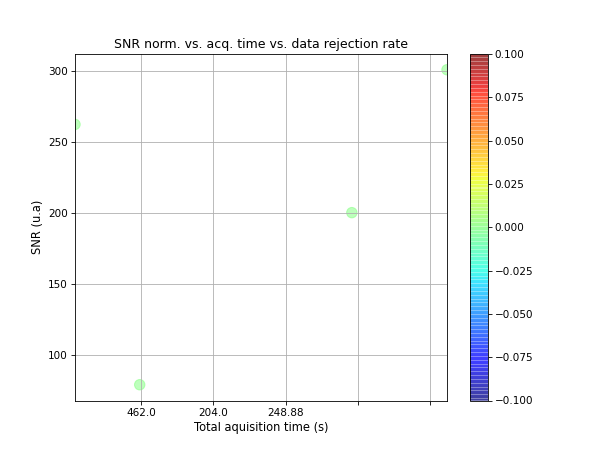

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc1f8ba90>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f5bc1f8ba90> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>


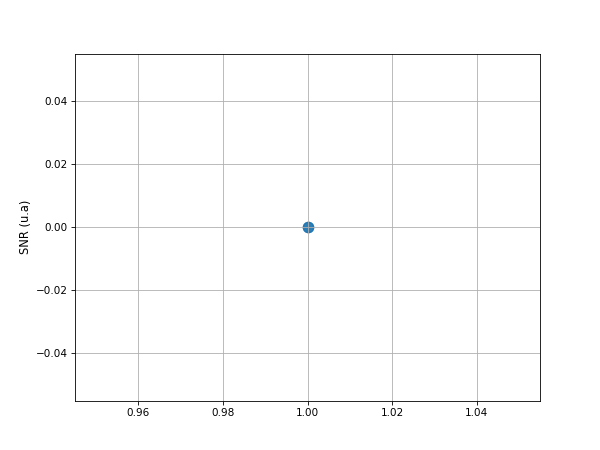

<IPython.core.display.Javascript object>


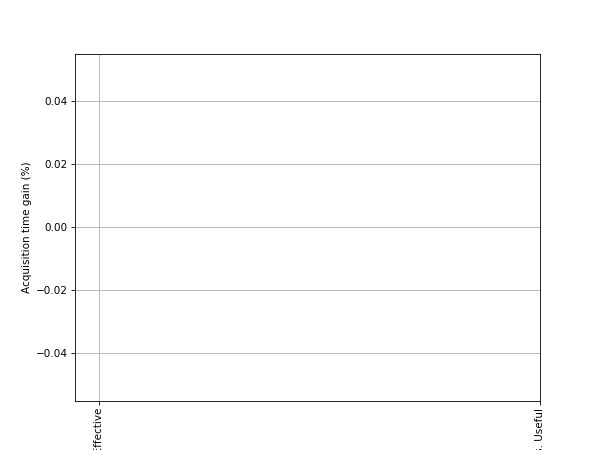

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[Text(0, 0, 'Theory vs. Effective'), Text(1, 0, 'Effective vs. Useful')]

In [18]:
# calculate theoretical scan time knowing NA and TR, neglicting resp. trig
df["dataset_acqtime"] = [o.tr / 1000.0 * (o.na + o.ds)  for o in df["dataset_raw_data__sequence_obj"]]
df["dataset_acqtime_eff"] = df["dataset_raw_data__sequence_eff_acquisition_time"]

# calculating data rejection rate
df["dataset_rejetion_rate_prct"] = (df["dataset_raw_data__data_rejection[0]_Pre-rejection_na"] - 
 df["dataset_raw_data__data_rejection[0]_Post-rejection_na"]) / df["dataset_raw_data__data_rejection[0]_Pre-rejection_na"] * 100.0

# calculating usefull acqusition time post-correction
df["dataset_acqtime_usefull"] = df["dataset_raw_data__sequence_eff_acquisition_time"] - (
    df["dataset_raw_data__sequence_eff_acquisition_time"] * df["dataset_rejetion_rate_prct"] / 100.0)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_acqtime"], df["dataset_snr_norm_voxpos"], c=df["dataset_rejetion_rate_prct"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Total aquisition time (s)", fontsize=11)
ax.set_xticklabels(df["dataset_acqtime"])
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))
ax.set_xlim([df["dataset_acqtime"].min(), df["dataset_acqtime"].max()])
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("SNR norm. vs. acq. time vs. data rejection rate")
ax.grid(True)

plt.colorbar(sc0)

fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_voxel_vol_cm3"], df["dataset_rejetion_rate_prct"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("")
ax.grid(True)

# relative gain estimations between
# theory and effective durations
# effective durations and post-corrected durations

df["dataset_acqtime_eff_gain"] = (df["dataset_acqtime_eff"] - df["dataset_acqtime"]) / df["dataset_acqtime"] * 100.0
df["dataset_acqtime_usefull_gain"] = (df["dataset_acqtime_usefull"] - df["dataset_acqtime_eff"]) / df["dataset_acqtime_eff"] * 100.0

xlabels = ["Theory vs. Effective", "Effective vs. Useful"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(2)
ax.bar(pos_bars, [df["dataset_acqtime_eff_gain"].mean(), 
                  df["dataset_acqtime_usefull_gain"].mean()],
       yerr=[df["dataset_acqtime_eff_gain"].std(), 
                  df["dataset_acqtime_usefull_gain"].std()])
ax.grid('on')
ax.set_ylabel("Acquisition time gain (%)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)  



## Group-averaged rejected spectrum (need to fix this with SC)
Average over all subjects the data rejected into one crappy spectrum

In [ ]:
#init
s_arr = None
dt_final = 0.0001

fig = plt.figure()
ax = fig.subplots()

# extract rej spectrum for each dataset
for s in df["dataset_raw_data__data_rejection[0]_Rejected spectrum_obj"]:
    # resample so that all data can be averaged
    old_t = np.arange(0, s.shape[0] * s.dt, s.dt)
    new_t = np.arange(0, s.shape[0] * dt_final, dt_final) 

    s_interp = np.interp(new_t, old_t, s)

    # convert to suspect
    s_MRSData = suspect.MRSData(s_interp, dt_final, s.f0)
    s_MRSData2 = s_MRSData.view(reco.MRSData2)        

    s_MRSData2 = s_MRSData2.correct_zerofill_nd()
    if(s_arr is None):
        s_arr = s
    else:
        s_arr = np.vstack((s_arr, s_MRSData2))

    ax.plot(s_MRSData2.frequency_axis_ppm(), np.real(s_MRSData2.spectrum()))

ax.grid('on')
ax.set_xlim(5, 0)
ax.set_xlabel("chemical shift (ppm)")
ax.set_ylabel("rejected spectra (real part)")

# make the average + std plot
s_mean = np.mean(s_arr, axis=0)
s_mean = suspect.MRSData(s_mean, dt_final, s.f0)
s_mean = s_mean.view(reco.MRSData2)

s_std = np.std(s_arr, axis=0)
s_std = suspect.MRSData(s_std, dt_final, s.f0)
s_std = s_std.view(reco.MRSData2)

fig = plt.figure()
ax = fig.subplots()
ax.plot(s_mean.frequency_axis_ppm(), np.real(s_mean.spectrum()))
ax.grid('on')
ax.set_xlim(5, 0)
ax.set_xlabel("chemical shift (ppm)")
ax.set_ylabel("average rejected spectra (real part)")


## Frequency realignment, data rejection: performance in terms of SNR and LW
- Evaluate data rejection approach with peak properties estimated before and after :)

In [ ]:
# extract SNR and LW estimation regarding frequency realignment and data rejection 
snr_before_datarej1 = df["dataset_raw_data__data_rejection[0]_Pre-rejection_snr"]
snr_before_datarej2 = df["dataset_raw_analysis-results_frequency realigning_snr"]
snr_after_datarej1 = df["dataset_raw_data__data_rejection[0]_Post-rejection_snr"]
snr_after_datarej2 = df["dataset_raw_analysis-results_data rejecting_snr"]
#
lw_before_datarej1 = df["dataset_raw_data__data_rejection[0]_Pre-rejection_lw"]
lw_before_datarej2 = df["dataset_raw_analysis-results_frequency realigning_lw"]
lw_after_datarej1 = df["dataset_raw_data__data_rejection[0]_Post-rejection_lw"]
lw_after_datarej2 = df["dataset_raw_analysis-results_data rejecting_lw"]
#
snr_before_realign = df["dataset_raw_analysis-results_apodizing_snr"]
snr_after_realign = df["dataset_raw_analysis-results_frequency realigning_snr"]
#
lw_before_realign = df["dataset_raw_analysis-results_apodizing_lw"]
lw_after_realign = df["dataset_raw_analysis-results_frequency realigning_lw"]

# SNR and LW gain calculation
snr_gain_datarej1 = (snr_after_datarej1 - snr_before_datarej1) / snr_before_datarej1 * 100.0
snr_gain_datarej2 = (snr_after_datarej2 - snr_before_datarej2) / snr_before_datarej2 * 100.0
lw_gain_datarej1 = (lw_after_datarej1 - lw_before_datarej1)
lw_gain_datarej2 = (lw_after_datarej2 - lw_before_datarej2)
#
snr_gain_realign = (snr_after_realign - snr_before_realign) / snr_before_realign * 100.0
lw_gain_realign = (lw_after_realign - lw_before_realign)

xlabels = ["Data rejection (1)", "Data rejection (2)", "Freq. realignment"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [snr_gain_datarej1.mean(), 
                  snr_gain_datarej2.mean(), 
                  snr_gain_realign.mean()], 
       yerr=[snr_gain_datarej1.std(), 
             snr_gain_datarej2.std(), 
             snr_gain_realign.std()])
ax.grid('on')
ax.set_ylabel("Relative SNR gain (%)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)       

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [lw_gain_datarej1.mean(), 
                  lw_gain_datarej2.mean(), 
                  lw_gain_realign.mean()], 
       yerr=[lw_gain_datarej1.std(), 
             lw_gain_datarej2.std(), 
             lw_gain_realign.std()])
ax.grid('on')
ax.set_ylabel("LW change (Hz)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)   
        

# Compare no trig, cardiac and resp gating
For subjects where scanned in the same study using various gating methods
* compare final SNR and LW
* compare peak properties variability (before data rejection)

In [ ]:

# find scans identical except for gating parameter
def sel_gating_tests(dataset_entry):
    if( (dataset_entry["patient"] == 300 and dataset_entry["study"] == 1) or
        (dataset_entry["patient"] == 307 and dataset_entry["study"] == 1) or
        (dataset_entry["patient"] == 311 and dataset_entry["study"] == 2) or
        (dataset_entry["patient"] == 336 and dataset_entry["study"] == 2) )
    r = (True)
    return(r)

rdb_sel_gating_tests = rdb.select_datasets(sel_gating_tests)

# extract SNR and LW estimation regarding frequency realignment and data rejection
gating_mode_header = [sim.gating_signal_source.NO_GATING, sim.gating_signal_source.CARDIAC_ECG, sim.gating_signal_source.CARDIAC_GATING, sim.gating_signal_source.RESP_GATING]
gating_none_cardiac_resp_list = np.full([4, 4], False)

snr_precor_none_cardiac_resp_list = np.full([4, 4], None)
lw_precor_none_cardiac_resp_list = np.full([4, 4], None)
snr_postcor_none_cardiac_resp_list = np.full([4, 4], None)
lw_postcor_none_cardiac_resp_list = np.full([4, 4], None)
peak_prop_mean_list = np.full([4, 4], None)
peak_prop_std_list = np.full([4, 4], None)

k_scan = -1
for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        k_scan += 1
        for this_scan in rdb_sel[this_patient][this_study]:
            # gating mode?
            g = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].sequence.gating_mode
            
            if(g == sim.gating_signal_source.NO_GATING):
                ind_gating = 0
            elif(g == sim.gating_signal_source.CARDIAC_ECG):
                ind_gating = 1
            elif(g == sim.gating_signal_source.CARDIAC_GATING):
                ind_gating = 2
            elif(g == sim.gating_signal_source.RESP_GATING):
                ind_gating = 3
                
            peak_prop = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Pre-rejection"]["measurements"]
            amp_mean = np.mean(peak_prop[:,0])
            amp_std = np.std(peak_prop[:,0])
            lw_mean = np.mean(peak_prop[:,1])
            lw_std = np.std(peak_prop[:,1])
            f_mean = np.mean(peak_prop[:,2])
            f_std = np.std(peak_prop[:,2]) 
            ph_mean = np.mean(peak_prop[:,3])
            ph_std = np.std(peak_prop[:,3])
            
            # snr and lw before cor
            snr_before_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["snr"]
            lw_before_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["lw"]
            # snr and lw after cor
            snr_after_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["snr"]
            lw_after_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["lw"]
                        
            # store
            gating_none_cardiac_resp_list[k_scan, ind_gating] = True
            snr_precor_none_cardiac_resp_list[k_scan, ind_gating] = snr_before_realign
            lw_precor_none_cardiac_resp_list[k_scan, ind_gating] = lw_before_realign
            snr_postcor_none_cardiac_resp_list[k_scan, ind_gating] = snr_after_realign
            lw_postcor_none_cardiac_resp_list[k_scan, ind_gating] = lw_after_realign
            peak_prop_mean_list[k_scan, ind_gating] = [amp_mean, lw_mean, f_mean, ph_mean]
            peak_prop_std_list[k_scan, ind_gating] = [amp_std, lw_std, f_std, ph_std]
     
        
        
        
        
        
        
        

# Quantification: group results...

In [ ]:
# %% init
from IPython import get_ipython
import matplotlib.pylab as plt
import matplotlib.colors as coco
from matplotlib import dates
from datetime import datetime
import mrs.reco as reco
import mrs.fit as fit
import mrs.sim as sim
import mrs.log as log
import mrs.aliases as xxx
import mrs.paths as default_paths
import numpy as np
import pickle
get_ipython().magic("clear")
plt.close("all")

get_ipython().magic("matplotlib notebook")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

import os
os.chdir("/home/tangir/crmbm/python/shrimp")


fdb = fit.data_db("/home/tangir/crmbm/data_fit/sc_db.pkl")


In [ ]:
# %% find best fit ever omg: probably Yolanda P2
snr_ts = 30
crb_ts = 5

def select_func_yo(d, rp, fp, dp):
    kl = list(rp._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = rp._analyze_results_dict[d.display_label]["snr"][last_job]

    params_fit_CRBs_rel = dp["params_fit_CRBs_rel"]
    CRBs_ok = (params_fit_CRBs_rel[xxx.m_Cho_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_Cr_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_NAA_CH3, xxx.p_cm] < crb_ts)
    
    r = (not d.is_dicom and
         "IR" not in d.display_label and
         d.sequence.name == "eja_svs_slaser" and
         CRBs_ok and
         final_snr > snr_ts)
    return(r)

data_list, data_reco_pipeline_list, data_fit_pipeline_list, pars_list = fdb.get_datasets(select_func_yo)

data = data_list[0]
params_fit_final = sim.params(data_fit_pipeline_list[0]._meta_bs)
params_fit_final[:] = pars_list[0]["params_fit_final"]
seq = data.sequence
seq.initialize()
params_fit_final.linklock[xxx.m_Cho_CH3, xxx.p_cm] = -500
params_fit_final.linklock[xxx.m_Cho_CH2, xxx.p_cm] = 500
params_fit_final.linklock[xxx.m_Cr_CH3, xxx.p_cm] = -600
params_fit_final.linklock[xxx.m_Cr_CH2, xxx.p_cm] = 600
params_fit_final.linklock[xxx.m_NAA_CH3, xxx.p_cm] = -700
params_fit_final.linklock[xxx.m_NAA_CH2, xxx.p_cm] = 700

data.display_spectrum_1d()

# fit plot
fig, ax = plt.subplots()
fit.disp_fit(ax, data, params_fit_final, seq, True, True, [xxx.m_Cho_CH3, xxx.m_Cho_CH2, xxx.m_Cr_CH3, xxx.m_Cr_CH2, xxx.m_Gln, xxx.m_Glu, xxx.m_NAA_CH3, xxx.m_NAA_CH2, xxx.m_mI])
fig.savefig("fig_fit.svg")

In [ ]:
# %% P1 : find one good scan per volunteer, best in terms of SNR
snr_ts = 5
crb_ts = 10

def select_func_yo(d, rp, fp, dp):
    kl = list(rp._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = rp._analyze_results_dict[d.display_label]["snr"][last_job]

    params_fit_CRBs_rel = dp["params_fit_CRBs_rel"]
    CRBs_ok = (params_fit_CRBs_rel[xxx.m_Cho_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_Cr_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_NAA_CH3, xxx.p_cm] < crb_ts)
    
    r = (not d.is_dicom and
         "IR" not in d.display_label and
         "P1" in d.patient_name and
         d.sequence.name == "eja_svs_slaser" and
         CRBs_ok and
         final_snr > snr_ts)
    return(r)

data_list_P1, data_reco_pipeline_list_P1, data_fit_pipeline_list_P1, pars_list_P1 = fdb.get_datasets(select_func_yo)

data_list_P1_2 = []
data_reco_pipeline_list_P1_2 = []
data_fit_pipeline_list_P1_2 = []
pars_list_P1_2 = []

ind_scanned = []
# keep best scan for each patient
for i, d in enumerate(data_list_P1):
    if(i not in ind_scanned):
        # find duplicates
        ind_patients = []
        for j, d2 in enumerate(data_list_P1):
            if(j not in ind_scanned and d.patient_name == d2.patient_name):
                ind_patients.append(j)
                ind_scanned.append(j)

        # find best snr
        best_snr = 0
        best_snr_ind = 0
        for k in ind_patients:
            dl = data_list_P1[k].display_label
            rp = data_reco_pipeline_list_P1[k]
            kl = list(rp._analyze_results_dict[dl]["snr"].keys())
            last_job = kl[-1]
            final_snr = rp._analyze_results_dict[dl]["snr"][last_job]

            if(final_snr >= best_snr):
                best_snr = final_snr
                best_snr_ind = k

        # got the highest snr scan for this patient
        data_list_P1_2.append(data_list_P1[best_snr_ind])
        data_reco_pipeline_list_P1_2.append(data_reco_pipeline_list_P1[best_snr_ind])
        data_fit_pipeline_list_P1_2.append(data_fit_pipeline_list_P1[best_snr_ind])
        pars_list_P1_2.append(pars_list_P1[best_snr_ind])

data_list_P1 = data_list_P1_2
data_reco_pipeline_list_P1 = data_reco_pipeline_list_P1_2
data_fit_pipeline_list_P1 = data_fit_pipeline_list_P1_2
pars_list_P1 = pars_list_P1_2
    
print("")
print("Filtered by SNR and sorted:")
patient_name_list = []
for d in data_list_P1:
    patient_name_list.append(d.patient_name)
patient_name_list.sort()

for p in patient_name_list:
    print(p)


In [ ]:
pars_abs_water_all = []
pars_abs_cre_all = []
pars_ratio_cre_all = []
for this_pars in pars_list_P1:
    pp = this_pars["params_fit_final_Ts_abs_water"]
    pars_abs_water_all.append(pp.copy())
    
    pp = this_pars["params_fit_final_Ts"]
    pp[:, xxx.p_cm] = pp[:, xxx.p_cm] * 7.5 / pp[xxx.m_Cr_CH3, xxx.p_cm]
    pars_abs_cre_all.append(pp.copy())
    
    pp = this_pars["params_fit_final_Ts"]
    pp[:, xxx.p_cm] = pp[:, xxx.p_cm] / pp[xxx.m_Cr_CH3, xxx.p_cm]
    pars_ratio_cre_all.append(pp.copy())
    
pars_abs_water_all = np.array(pars_abs_water_all)
pars_abs_cre_all = np.array(pars_abs_cre_all)
pars_ratio_cre_all = np.array(pars_ratio_cre_all)

pars_abs_water_mean = sim.params(data_fit_pipeline_list_P1[0]._meta_bs)
pars_abs_water_mean[:] = np.mean(pars_abs_water_all, axis=0)
pars_abs_water_std = np.std(pars_abs_water_all, axis=0)

pars_abs_cre_mean = sim.params(data_fit_pipeline_list_P1[0]._meta_bs)
pars_abs_cre_mean[:] = np.mean(pars_abs_cre_all, axis=0)
pars_abs_cre_std = np.std(pars_abs_cre_all, axis=0)

# human range
p_human_min = sim.params(data_fit_pipeline_list_P1[0]._meta_bs).set_default_min()
p_human_max = sim.params(data_fit_pipeline_list_P1[0]._meta_bs).set_default_max()

fig, ax = plt.subplots()
fit.disp_bargraph(ax, [p_human_min, pars_abs_water_mean, pars_abs_cre_mean, p_human_max], [p_human_min*0, pars_abs_water_std, pars_abs_cre_std, p_human_max*0], ["Healthy human brain min/max concentration range", "Estimated concentrations", "Estimated concentrations assuming Cre", "Healthy human brain min/max concentration range"], False, False, False, False, xxx.p_cm, [xxx.m_Cho_CH3, xxx.m_Cr_CH3, xxx.m_Gln, xxx.m_Glu, xxx.m_NAA_CH3, xxx.m_mI], 0.2)
ax.set_ylim([0, 25])
ax.set_xticklabels(["tCho", "tCr", "Gln", "Glu", "mI", "NAA"], rotation=0)
ax.set_ylabel("Abs. concentration [mmol/kg]")
fig.savefig("fig_group_mean.svg")

pars_ratio_cre_mean = sim.params(data_fit_pipeline_list_P1[0]._meta_bs)
pars_ratio_cre_mean[:] = np.mean(pars_ratio_cre_all, axis=0)
pars_ratio_cre_std = np.std(pars_ratio_cre_all, axis=0)

print("tCho/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_Cho_CH3, xxx.p_cm], pars_ratio_cre_std[xxx.m_Cho_CH3, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_Cho_CH3, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_Cho_CH3, xxx.p_cm]))
print("Gln/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_Gln, xxx.p_cm], pars_ratio_cre_std[xxx.m_Gln, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_Gln, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_Gln, xxx.p_cm]))
print("Glu/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_Glu, xxx.p_cm], pars_ratio_cre_std[xxx.m_Glu, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_Glu, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_Glu, xxx.p_cm]))
print("mI/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_mI, xxx.p_cm], pars_ratio_cre_std[xxx.m_mI, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_mI, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_mI, xxx.p_cm]))
print("NAA/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_NAA_CH3, xxx.p_cm], pars_ratio_cre_std[xxx.m_NAA_CH3, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_NAA_CH3, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_NAA_CH3, xxx.p_cm]))


In [ ]:
# %% P2 : find one good scan per volunteer, best in terms of SNR
snr_ts = 5
crb_ts = 10

def select_func_yo(d, rp, fp, dp):
    kl = list(rp._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = rp._analyze_results_dict[d.display_label]["snr"][last_job]

    params_fit_CRBs_rel = dp["params_fit_CRBs_rel"]
    CRBs_ok = (params_fit_CRBs_rel[xxx.m_Cho_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_Cr_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_NAA_CH3, xxx.p_cm] < crb_ts)
    
    r = (not d.is_dicom and
         "IR" not in d.display_label and
         "P2" in d.patient_name and
         d.sequence.name == "eja_svs_slaser" and
         CRBs_ok and
         final_snr > snr_ts)
    return(r)

data_list_P2, data_reco_pipeline_list_P2, data_fit_pipeline_list_P2, pars_list_P2 = fdb.get_datasets(select_func_yo)

data_list_P2_2 = []
data_reco_pipeline_list_P2_2 = []
data_fit_pipeline_list_P2_2 = []
pars_list_P2_2 = []

ind_scanned = []
# keep best scan for each patient
for i, d in enumerate(data_list_P2):
    if(i not in ind_scanned):
        # find duplicates
        ind_patients = []
        for j, d2 in enumerate(data_list_P2):
            if(j not in ind_scanned and d.patient_name == d2.patient_name):
                ind_patients.append(j)
                ind_scanned.append(j)

        # find best snr
        best_snr = 0
        best_snr_ind = 0
        for k in ind_patients:
            dl = data_list_P2[k].display_label
            rp = data_reco_pipeline_list_P2[k]
            kl = list(rp._analyze_results_dict[dl]["snr"].keys())
            last_job = kl[-1]
            final_snr = rp._analyze_results_dict[dl]["snr"][last_job]

            if(final_snr >= best_snr):
                best_snr = final_snr
                best_snr_ind = k

        # got the highest snr scan for this patient
        data_list_P2_2.append(data_list_P2[best_snr_ind])
        data_reco_pipeline_list_P2_2.append(data_reco_pipeline_list_P2[best_snr_ind])
        data_fit_pipeline_list_P2_2.append(data_fit_pipeline_list_P2[best_snr_ind])
        pars_list_P2_2.append(pars_list_P2[best_snr_ind])

data_list_P2 = data_list_P2_2
data_reco_pipeline_list_P2 = data_reco_pipeline_list_P2_2
data_fit_pipeline_list_P2 = data_fit_pipeline_list_P2_2
pars_list_P2 = pars_list_P2_2

print("")
print("Filtered by SNR and sorted:")
patient_name_list = []
for d in data_list_P2:
    patient_name_list.append(d.patient_name)
patient_name_list.sort()

for p in patient_name_list:
    print(p)

In [ ]:
# merge with previous P1s
data_list_P1P2 = data_list_P1 + data_list_P2
data_reco_pipeline_list_P1P2 = data_reco_pipeline_list_P1 + data_reco_pipeline_list_P2
data_fit_pipeline_list_P1P2 = data_fit_pipeline_list_P1 + data_fit_pipeline_list_P2
pars_list_P1P2 = pars_list_P1 + pars_list_P2

# sort according to number
patient_name_list = []
for d in data_list_P1P2:
    patient_name_list.append(d.patient_name)
    
patient_name_list = np.array(patient_name_list)
inds = np.argsort(patient_name_list)

data_list_P1P2_sorted = []
data_reco_pipeline_list_P1P2_sorted = []
data_fit_pipeline_list_P1P2_sorted = []
pars_list_P1P2_sorted = []
for ii in inds:
    data_list_P1P2_sorted.append(data_list_P1P2[ii])
    data_reco_pipeline_list_P1P2_sorted.append(data_reco_pipeline_list_P1P2[ii])
    data_fit_pipeline_list_P1P2_sorted.append(data_fit_pipeline_list_P1P2[ii])
    pars_list_P1P2_sorted.append(pars_list_P1P2[ii])

patient_names = []
for d in data_list_P1P2_sorted:
    patient_names.append(d.patient_name)
    print(d.patient_name)


In [ ]:
pars_abs_water_all = []
pars_abs_cre_all = []
pars_crb_water_all = []
pars_crb_cre_all = []
caption_list = []
P1P2s_list = [300, 304, 311, 313, 314, 319, 333, 336]
P1P2s_list = [311, 313, 314, 319]  # to set manually....

for this_pars, this_pn in zip(pars_list_P1P2_sorted, patient_names):
    this_patient_number = int(this_pn[0:3])
    if(this_patient_number in P1P2s_list):
        pp = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp[:] = this_pars["params_fit_final_Ts_abs_water"]
        pars_abs_water_all.append(pp)
        # crb
        pp2 = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp2[:] = this_pars["params_fit_final_Ts_abs_water"] * this_pars["params_fit_CRBs_rel"] / 100.0
        pars_crb_water_all.append(pp2)
        
        pp3 = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp3[:] = this_pars["params_fit_final_Ts_abs_water"]
        pp3[:, xxx.p_cm] = pp3[:, xxx.p_cm] / pp3[xxx.m_Cr_CH3, xxx.p_cm]
        pars_abs_cre_all.append(pp3)
        # crb
        pp4 = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp4[:, xxx.p_cm] = this_pars["params_fit_final_Ts_abs_water"][:, xxx.p_cm]/this_pars["params_fit_final_Ts_abs_water"][xxx.m_Cr_CH3, xxx.p_cm] * (this_pars["params_fit_CRBs_abs"][:, xxx.p_cm]/this_pars["params_fit_final_Ts_abs_water"][:, xxx.p_cm] + this_pars["params_fit_CRBs_abs"][xxx.m_Cr_CH3, xxx.p_cm]/this_pars["params_fit_final_Ts_abs_water"][xxx.m_Cr_CH3, xxx.p_cm])
        pars_crb_cre_all.append(pp4)

        caption_list.append(this_pn)

fig, ax = plt.subplots()
fit.disp_bargraph(ax, pars_abs_water_all, pars_crb_water_all, caption_list, False, False, False, False, xxx.p_cm, [xxx.m_Cho_CH3, xxx.m_Cr_CH3, xxx.m_NAA_CH3, xxx.m_mI], 0.1)
ax.set_xticklabels(["tCho", "tCr", "mI", "NAA"], rotation=0)
ax.set_ylabel("Abs. concentration [mmol/kg]")
fig.savefig("fig_group_repro_cm_abs.svg")

fig, ax = plt.subplots()
fit.disp_bargraph(ax, pars_abs_cre_all, pars_crb_cre_all, caption_list, False, False, False, False, xxx.p_cm, [xxx.m_Cho_CH3, xxx.m_Cr_CH3, xxx.m_NAA_CH3, xxx.m_mI], 0.1)
ax.set_xticklabels(["tCho", "tCr", "mI", "NAA"], rotation=0)
ax.set_ylabel("Cr ratios")
fig.savefig("fig_group_repro_ratios.svg")


# Some more questions

* How long shoud we scan vs. SNR vs. BMI (including all NAs)
* Data rejection rate vs. SNR/BMI/vref...
* Choosing SNR/LW threshold
* Percentage of exploitable scans/patients

* compare protocols 20/1, 10/2, 5/5 when possible

* Water LW looks visually good in SC compared to brain right? So why is the data so different?

* Find why MRS quality data varies from one subject to another (THIS IS CRITICAL)
    * Things to check:
    * B0 (LW)
    * B1 (Vref)
    * BMI stuff (height/weight)
    * unperfect breathing gating (check respiratory stability?)
    * susceptiblity effects (check LW variation STD)
    * lungs are closer to SC for small subjects (check voxel position, subject height)
    * When doing this, normalize SNR per volume, NA, include NA rejected ? already done? voxel size, position ?

* SNR according to NA plot, normalized or not

* check for intra-subject repro if any data

* What does CRB errors depend on? scatter plots CRBS(met) = f(SNR, FWHM)
    * Use this to choose which metabolites to include, how many NA are really needed

* CRBs: relative / absolute? work according to the last quantification review!

* Percentage of acceptable or quantifiable MR spectra?

* About the >4.7ppm artefact, correlate with shimming voltages too

* What about heart and resp bpm?